# San Francisco Crime Prediction 

In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as plt

import seaborn as sns
#sns.set_style('whitegrid')


from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

from datetime import datetime

from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy

# natural language processing
import nltk

%matplotlib inline

### Reading Training Data Set

In [15]:
#reading the training data set
SNF = pd.read_csv("train-2.csv" , sep=',')
# names=['Dates','Category','Descript','DayOfWeek','PdDistrict','Resolution','Address','X','Y']

# printing size of data frame
print ('Size of data frame: ',SNF.shape)


Size of data frame:  (878049, 9)


### SAN FRANCISCO CRIME DATA MAP

#### Clean up wrong X and Y values (very few of them)

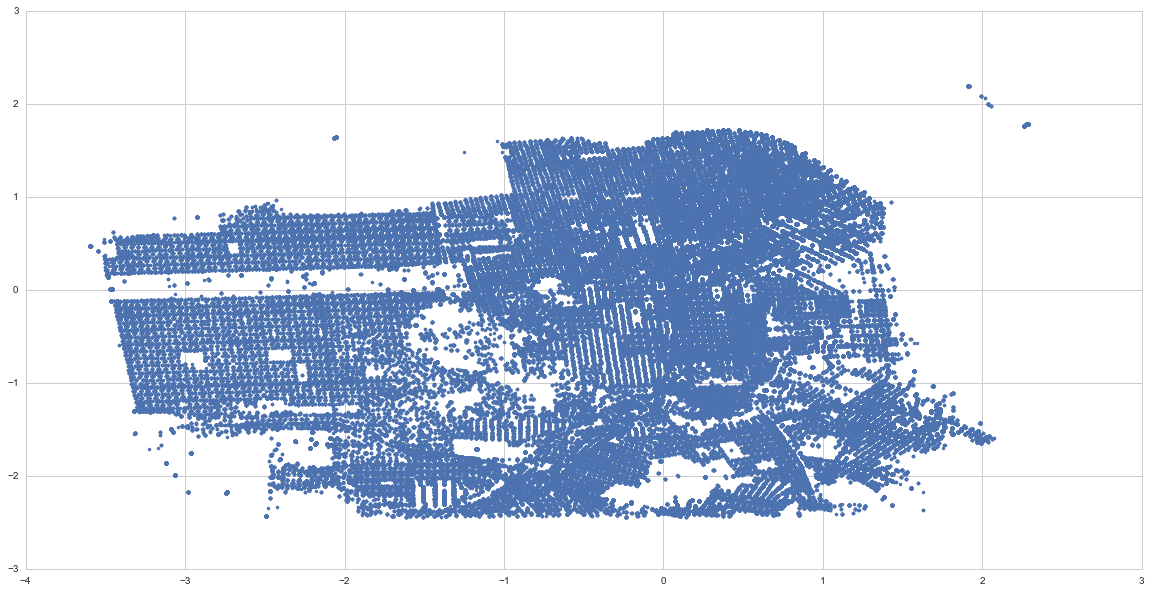

In [64]:

xy_scaler = preprocessing.StandardScaler()
xy_scaler.fit(SNF[["X","Y"]])
SNF[["X","Y"]] = xy_scaler.transform(SNF[["X","Y"]])

SNF=SNF[abs(SNF["Y"])<100]
SNF.index=range(len(SNF))

plt.figure(figsize=(20,10))
plt.plot(SNF["X"],SNF["Y"],'.')
plt.show()

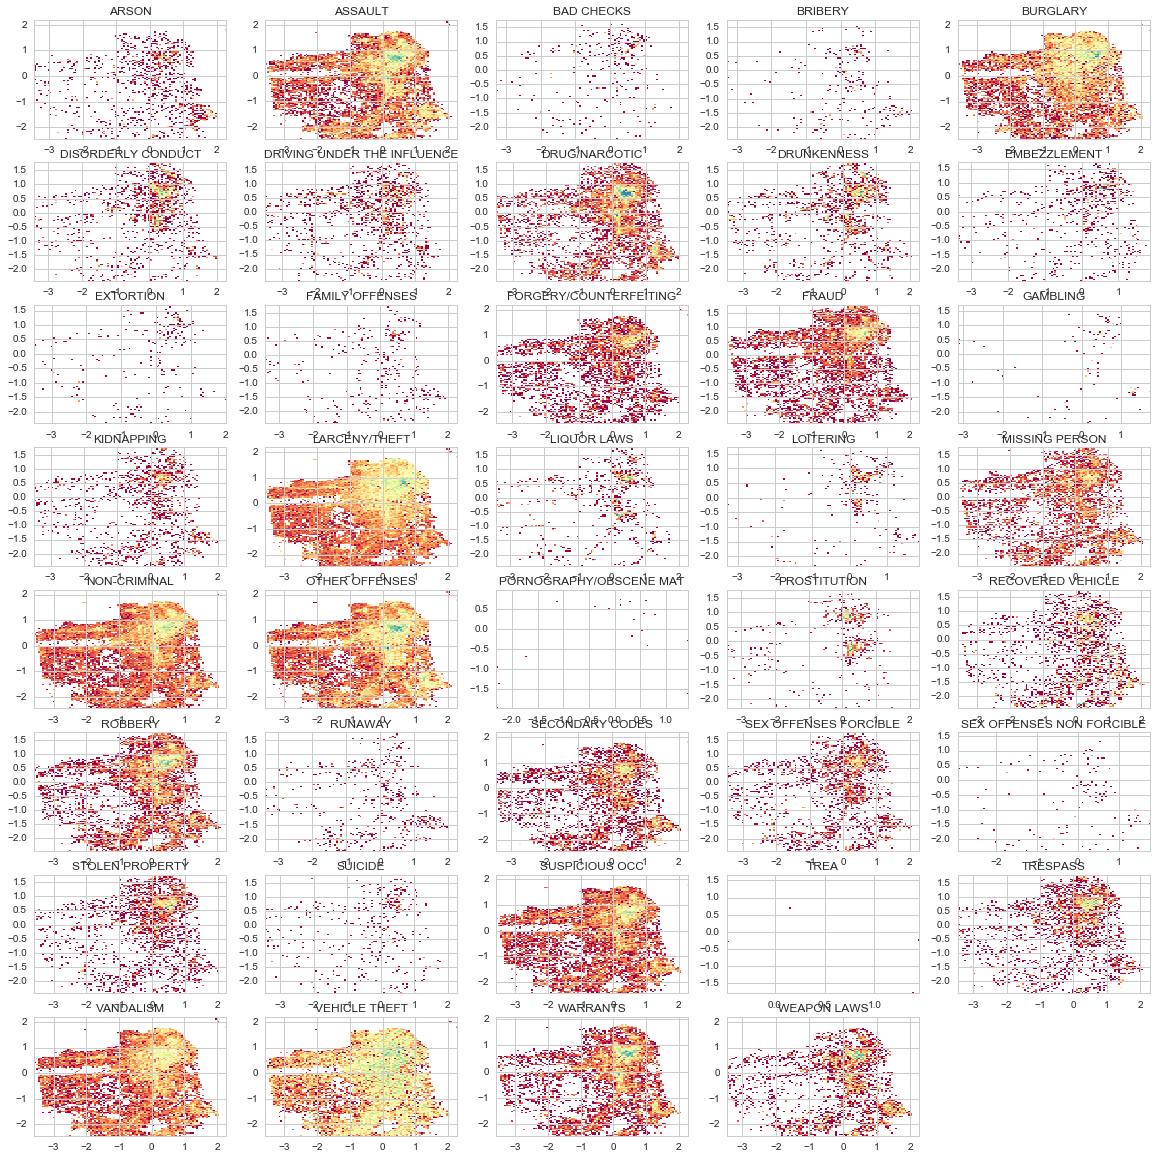

In [117]:
# 2D histogram of the response variable: Category
NX=100
NY=100
groups = SNF.groupby('Category')
ii=1
plt.figure(figsize=(20, 20))
for name, group in groups:
    plt.subplot(8,5,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',cmap=plt.cm.Spectral,extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
#     plt.figure(ii)
#     plt.plot(group.X,group.Y,'.')
    ii+=1
del groups

In [61]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year

def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

In [3]:
# checking whether index is unique
SNF.index.is_unique

True

In [3]:
#getting the column names
SNF.columns.values

array(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'], dtype=object)

In [4]:
# defining a function to find missing values
def count_missing(frame):
    return (frame.shape[0] * frame.shape[1]) - frame.count().sum()
# checking for missing values in data frame
print ('Missing Values: ', count_missing(SNF))

Missing Values:  0


In [66]:
#getting head of data set
SNF.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CategoryLength
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.123732,0.313018,8
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.123732,0.313018,14
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-0.063274,1.381346,14
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-0.167381,1.400312,13
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-0.631787,0.186493,13


In [67]:
#getting tail of data set
SNF.tail()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CategoryLength
877977,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-1.434470,-2.192394,7
877978,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-0.972939,-1.452002,13
877979,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,0.766191,0.547534,13
877980,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,1.274761,0.561666,9
877981,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,1.100967,-1.192781,22


In [68]:
#checking data frame info
SNF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 877981
Data columns (total 10 columns):
Dates             877982 non-null object
Category          877982 non-null object
Descript          877982 non-null object
DayOfWeek         877982 non-null object
PdDistrict        877982 non-null object
Resolution        877982 non-null object
Address           877982 non-null object
X                 877982 non-null float64
Y                 877982 non-null float64
CategoryLength    877982 non-null int64
dtypes: float64(2), int64(1), object(7)
memory usage: 73.7+ MB


In [57]:
#length of each words in the category column
def word_length(SNF):
    SNF['CategoryLength'] = SNF['Category'].apply(len)
    return SNF.head()

In [58]:
word_length(SNF)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CategoryLength
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.123732,0.313018,8
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.123732,0.313018,14
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-0.063274,1.381346,14
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-0.167381,1.400312,13
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-0.631787,0.186493,13


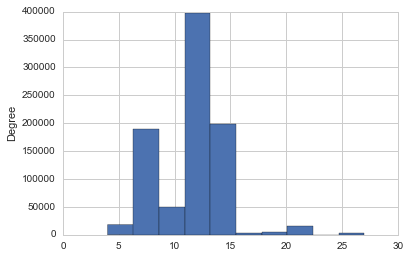

In [82]:
SNF['CategoryLength'].plot(bins=10,kind="hist")

In [50]:
#category length statistics
SNF['CategoryLength'].describe()

count    878049.000000
mean         11.741640
std           3.122997
min           4.000000
25%           9.000000
50%          13.000000
75%          14.000000
max          27.000000
Name: CategoryLength, dtype: float64

In [70]:
#category of length 27 : max
SNF[SNF['CategoryLength']==27]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CategoryLength
351,2015-05-13 00:56:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Wednesday,TARAVAL,"ARREST, BOOKED",19TH AV / WAWONA ST,-2.077344,-1.224183,27
1437,2015-05-03 02:17:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Sunday,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,0.787599,0.365217,27
1507,2015-05-02 23:10:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Saturday,BAYVIEW,"ARREST, BOOKED",WILLIAMS AV / VENUS ST,0.976423,-1.530991,27
1610,2015-05-02 19:00:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Saturday,RICHMOND,"ARREST, BOOKED",7TH AV / CLEMENT ST,-1.689982,0.656099,27
1658,2015-05-02 16:56:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Saturday,BAYVIEW,"ARREST, BOOKED",25TH ST / ILLINOIS ST,1.421832,-0.585345,27
1845,2015-05-02 00:54:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF DRUGS,Saturday,SOUTHERN,"ARREST, BOOKED",10TH ST / BRYANT ST,0.515113,0.137125,27
1856,2015-05-02 00:12:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Saturday,SOUTHERN,"ARREST, BOOKED",400 Block of 10TH ST,0.483378,0.160500,27
2663,2015-04-30 00:15:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Thursday,BAYVIEW,"ARREST, BOOKED",3RD ST / PALOU AV,1.257346,-1.366437,27
3694,2015-04-27 13:54:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Monday,INGLESIDE,"ARREST, BOOKED",1200 Block of GIRARD ST,0.883288,-2.064516,27
5176,2015-04-17 00:35:00,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Friday,TARAVAL,"ARREST, BOOKED",CRESPI DR / JUANBAUTISTA CR,-2.165810,-2.011248,27


In [76]:
len(SNF[SNF['CategoryLength']==27])

2268

In [13]:
# category of length 4 : min
SNF[SNF['CategoryLength']==4]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CategoryLength
21002,2015-02-03 17:05:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Tuesday,BAYVIEW,NONE,300 Block of 20TH ST,-122.386105,37.760692,4
93716,2014-02-17 06:38:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Monday,MISSION,"ARREST, BOOKED",500 Block of CASTRO ST,-122.434995,37.760070,4
107733,2013-11-30 05:59:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Saturday,NORTHERN,"ARREST, BOOKED",700 Block of POLK ST,-122.419250,37.783807,4
192190,2012-10-20 22:27:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Saturday,BAYVIEW,NONE,1300 Block of ARMSTRONG AV,-122.387620,37.723535,4
316490,2010-12-31 16:20:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Friday,CENTRAL,"ARREST, BOOKED",2300 Block of STOCKTON ST,-122.410661,37.807428,4
337880,2010-09-09 11:55:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Thursday,BAYVIEW,NONE,1000 Block of IOWA ST,-122.391708,37.753872,4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116481908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1171c1668>]], dtype=object)

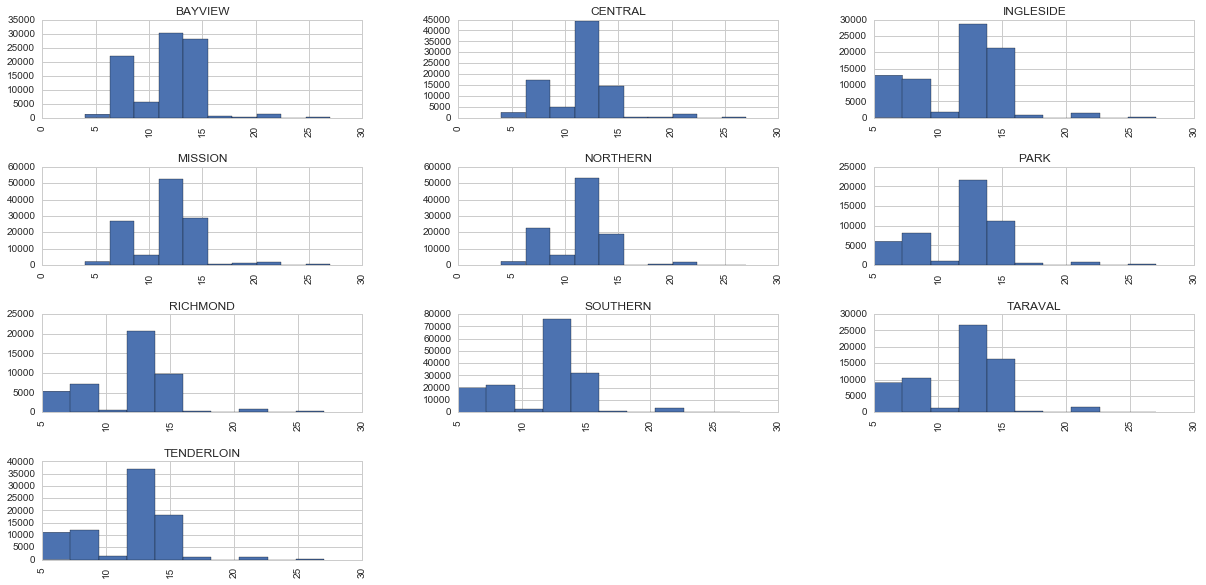

In [80]:
SNF.hist(column='CategoryLength',by=SNF['PdDistrict'],bins=10,figsize=(20,10))

In [78]:
#processing dates column
def compute_year_month(SNF):
    SNF['Dates'] = pd.to_datetime(SNF['Dates'])
    SNF['year'], SNF['month'] = SNF['Dates'].apply(lambda x: x.year), SNF['Dates'].apply(lambda x: x.month)
    return SNF.head()

In [79]:
compute_year_month(SNF)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,CategoryLength,year,month
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.123732,0.313018,8,2015,5
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.123732,0.313018,14,2015,5
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-0.063274,1.381346,14,2015,5
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-0.167381,1.400312,13,2015,5
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-0.631787,0.186493,13,2015,5


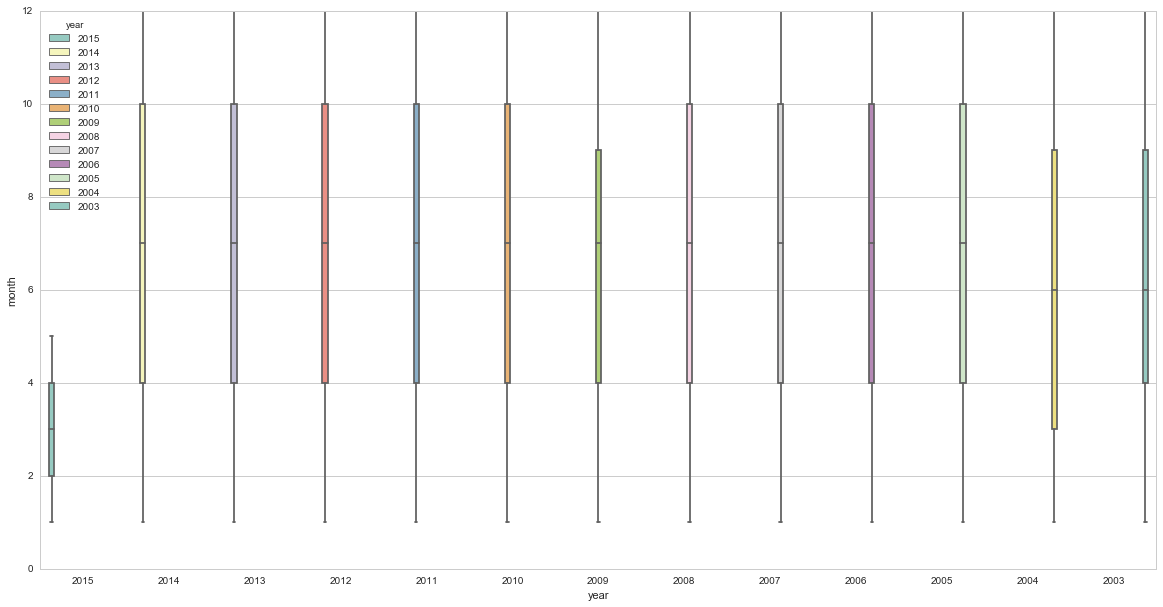

In [81]:
plt.figure(figsize=(20,10))
sns.boxplot(x=SNF["year"], y=SNF["month"], hue="year",data=SNF, palette="Set3",whis=1.5)

In [120]:
# getting unique counts : Descript column
ds = SNF['Descript'].unique()
ds_dict = {value:index for index,value in enumerate(ds)}
desc = SNF['Descript'].map(ds_dict)
ds_dict

{'ABANDONMENT OF CHILD': 517,
 'ABORTION': 617,
 'ACCESS CARD INFORMATION, PUBLICATION OF': 755,
 'ACCESS CARD INFORMATION, THEFT OF': 298,
 'ACCIDENTAL BURNS': 844,
 'ACCIDENTAL SHOOTING': 695,
 'ACTS AGAINST PUBLIC TRANSIT': 520,
 'ADVERTISING DISTRIBUTORS PERMIT VIOLATION': 671,
 'AEROSOL CONTAINER; SALE, PURCHASE OR POSSESSION OF': 444,
 'AFFIXING ADVERTISMENTS TO POLES': 842,
 'AGGRAVATED ASSAULT OF POLICE OFFICER, SNIPING': 864,
 'AGGRAVATED ASSAULT OF POLICE OFFICER,BODILY FORCE': 289,
 'AGGRAVATED ASSAULT ON POLICE OFFICER WITH A GUN': 790,
 'AGGRAVATED ASSAULT ON POLICE OFFICER WITH A KNIFE': 475,
 'AGGRAVATED ASSAULT WITH A DEADLY WEAPON': 80,
 'AGGRAVATED ASSAULT WITH A GUN': 132,
 'AGGRAVATED ASSAULT WITH A KNIFE': 85,
 'AGGRAVATED ASSAULT WITH BODILY FORCE': 10,
 'AGGRESSIVE SOLICITING': 553,
 'AID OR HARBOR FELON': 622,
 'AIDED CASE': 50,
 'AIDED CASE -PROPERTY FOR DESTRUCTION': 87,
 'AIDED CASE, DOG BITE': 163,
 'AIDED CASE, INJURED PERSON': 110,
 'AIDED CASE, MENTAL DIS

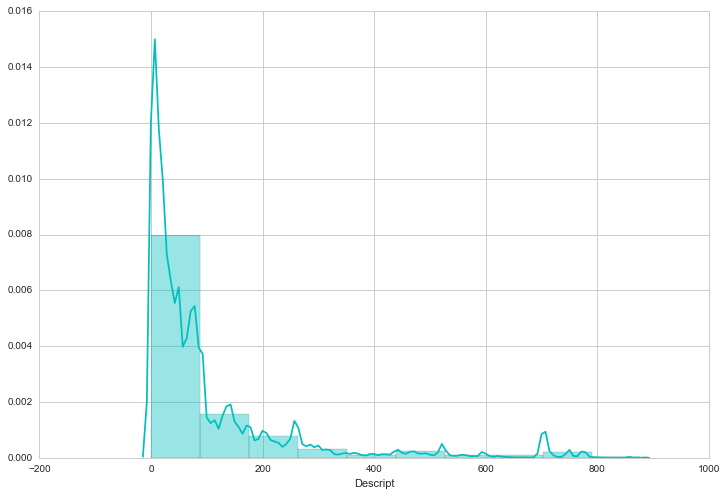

In [130]:
#draw histogram of the distribution of Descript Column
plt.figure(figsize=(12,8))
sns.distplot(desc,bins=10,kde=True,color='c')

In [123]:
# getting unique counts : Resolution column
rs = SNF['Resolution'].unique()
rs_dict = {value:index for index,value in enumerate(rs)}
r = SNF['Resolution'].map(rs_dict)
rs_dict

{'ARREST, BOOKED': 0,
 'ARREST, CITED': 2,
 'CLEARED-CONTACT JUVENILE FOR MORE INFO': 8,
 'COMPLAINANT REFUSES TO PROSECUTE': 11,
 'DISTRICT ATTORNEY REFUSES TO PROSECUTE': 14,
 'EXCEPTIONAL CLEARANCE': 6,
 'JUVENILE ADMONISHED': 12,
 'JUVENILE BOOKED': 4,
 'JUVENILE CITED': 13,
 'JUVENILE DIVERTED': 10,
 'LOCATED': 7,
 'NONE': 1,
 'NOT PROSECUTED': 9,
 'PROSECUTED BY OUTSIDE AGENCY': 15,
 'PROSECUTED FOR LESSER OFFENSE': 16,
 'PSYCHOPATHIC CASE': 3,
 'UNFOUNDED': 5}

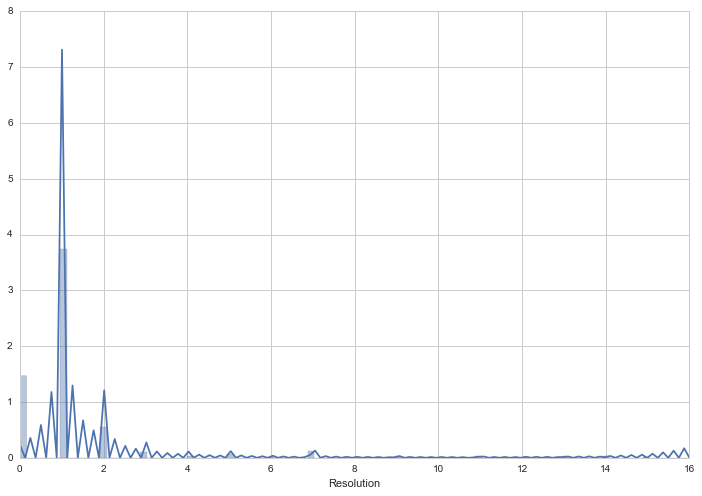

In [126]:
#draw histogram of the distribution of PdDistrict
plt.figure(figsize=(12,8))
sns.distplot(r,bins=100,kde=True)

### Types of Crimes 

 - Crime against person : murder , aggravated assaut, rape , robbery etc
 
 - Crime against property : theft of property, auto theft , arson , burglary etc
 
 - Crime against morality : prostitution, illegal gambling , illegal drug use, also called victimless crimes
 
 - White-Collar Crime : committed by high social status persons in the context of their occupation ,eg embezzling,
 
 - Organized crime : committed by group of people, eg. illegal distribution of goods, drug trade, weapon smuggling, money laundering etc
 
 

### Text pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.
We'll begin by

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).
As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the strings in our text column, then we can just use apply() in pandas do process all the text in the DataFrame.
First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:

In [14]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

### Vectorization
Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.
Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:
Count how many times does a word occur in each message (Known as term frequency)
Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:
Each vector will have as many dimensions as there are unique words in the corpus. We will first use SciKit Learn's CountVectorizer. This model will convert a collection of text documents to a matrix of token counts.
We can imagine this as a n-Dimensional matrix. Where the (n-1)-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.Since there are so many documents, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a Sparse Matrix.

In [84]:
# X - predictor variables
X = SNF.drop(['Category','Descript','Resolution','CategoryLength','year','month'],axis=1,inplace=False)
df_X = pd.DataFrame(X)
df_X.head()

,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-0.123732,0.313018
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-0.123732,0.313018
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-0.063274,1.381346
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-0.167381,1.400312
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-0.631787,0.186493


In [131]:
# y - response variable
ytarget = SNF['Category']
ytarget.head()

0          WARRANTS
1    OTHER OFFENSES
2    OTHER OFFENSES
3     LARCENY/THEFT
4     LARCENY/THEFT
Name: Category, dtype: object

In [13]:
# getting unique counts : DayOfWeek column
day = df_X['DayOfWeek'].unique()
day_dict = {value:index for index,value in enumerate(day)}
dy = df_X['DayOfWeek'].map(day_dict)
day_dict

{'Friday': 5,
 'Monday': 2,
 'Saturday': 4,
 'Sunday': 3,
 'Thursday': 6,
 'Tuesday': 1,
 'Wednesday': 0}

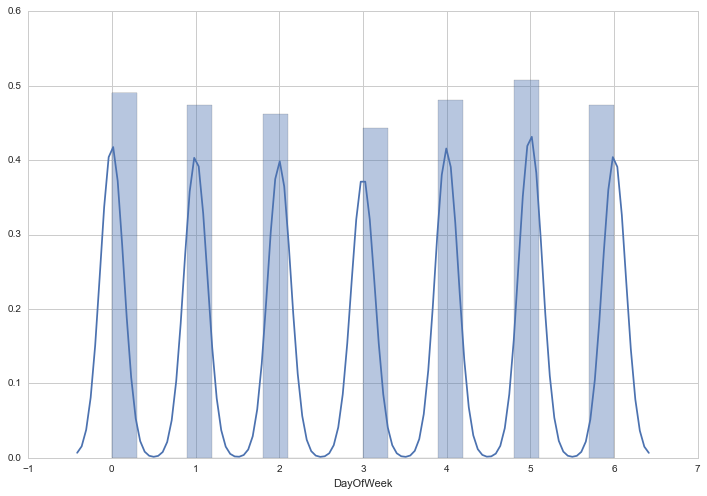

In [14]:
#draw histogram of the distribution of PdDistrict
plt.figure(figsize=(12,8))
sns.distplot(dy,bins=20,kde=True)

In [66]:
# getting unique counts : Category column
district = df_X['PdDistrict'].unique()
district_dict = {value:index for index,value in enumerate(district)}
d = df_X['PdDistrict'].map(district_dict)
district_dict

{'BAYVIEW': 3,
 'CENTRAL': 5,
 'INGLESIDE': 2,
 'MISSION': 8,
 'NORTHERN': 0,
 'PARK': 1,
 'RICHMOND': 4,
 'SOUTHERN': 9,
 'TARAVAL': 6,
 'TENDERLOIN': 7}

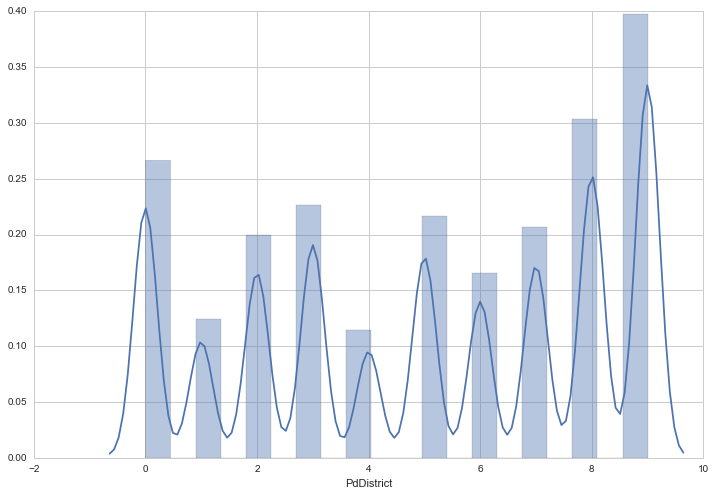

In [67]:
#draw histogram of the distribution of PdDistrict
plt.figure(figsize=(12,8))
sns.distplot(d,bins=20,kde=True)

In [35]:
# getting unique counts : Category column
categories = ytarget.unique()
category_dict = {value:index for index,value in enumerate(categories)}
y = ytarget.map(category_dict)
category_dict

{'ARSON': 25,
 'ASSAULT': 7,
 'BAD CHECKS': 35,
 'BRIBERY': 28,
 'BURGLARY': 9,
 'DISORDERLY CONDUCT': 24,
 'DRIVING UNDER THE INFLUENCE': 21,
 'DRUG/NARCOTIC': 13,
 'DRUNKENNESS': 11,
 'EMBEZZLEMENT': 29,
 'EXTORTION': 33,
 'FAMILY OFFENSES': 26,
 'FORGERY/COUNTERFEITING': 12,
 'FRAUD': 18,
 'GAMBLING': 34,
 'KIDNAPPING': 19,
 'LARCENY/THEFT': 2,
 'LIQUOR LAWS': 27,
 'LOITERING': 31,
 'MISSING PERSON': 17,
 'NON-CRIMINAL': 5,
 'OTHER OFFENSES': 1,
 'PORNOGRAPHY/OBSCENE MAT': 38,
 'PROSTITUTION': 23,
 'RECOVERED VEHICLE': 37,
 'ROBBERY': 6,
 'RUNAWAY': 20,
 'SECONDARY CODES': 15,
 'SEX OFFENSES FORCIBLE': 22,
 'SEX OFFENSES NON FORCIBLE': 32,
 'STOLEN PROPERTY': 14,
 'SUICIDE': 30,
 'SUSPICIOUS OCC': 10,
 'TREA': 36,
 'TRESPASS': 16,
 'VANDALISM': 4,
 'VEHICLE THEFT': 3,
 'WARRANTS': 0,
 'WEAPON LAWS': 8}

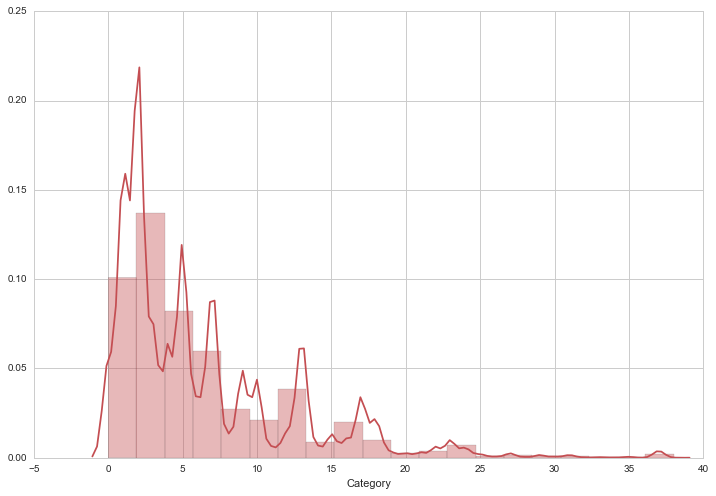

In [40]:
#draw histogram of the distribution of the response variable: y
plt.figure(figsize=(12,8))
sns.set_color_codes()
sns.distplot(y,bins=20,kde=True,color='r')

## Model Building

In [15]:
print ("Creating the bag of words...\n\n")

token = nltk.word_tokenize(df_X)

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
# Convert a collection of text documents to a matrix of token counts
# This implementation produces a sparse representation of the counts using
# scipy.sparse.coo_matrix.
#
vectorizer = CountVectorizer(min_df=1)

#fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(token)

# Numpy arrays are easy to work with, so convert the result to an array
train_data_features = train_data_features.toarray()

# print the shape of matrix
print (train_data_features.shape)
train_data_features

Creating the bag of words...




LookupError: 
**********************************************************************
  Resource 'tokenizers/punkt/PY3/english.pickle' not found.
  Please use the NLTK Downloader to obtain the resource:  >>>
  nltk.download()
  Searched in:
    - '/Users/theophilus/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************

In [97]:
#getting corpus size or total number of vocab words
print("Corpus Size: %s" %len(vectorizer.get_feature_names()))

Corpus Size: 2141


In [99]:
# print vocabs : last 50
vocab = vectorizer.get_feature_names()[:50]
print (vocab)

['100', '1000', '101', '10th', '1100', '11th', '1200', '12th', '1300', '13th', '1400', '14th', '1500', '15th', '1600', '16th', '1700', '17th', '1800', '18th', '1900', '19th', '1st', '200', '2000', '20th', '2100', '21st', '2200', '22nd', '2300', '23rd', '2400', '24th', '2500', '25th', '2600', '26th', '2700', '27th', '280', '2800', '28th', '2900', '29th', '2nd', '300', '3000', '30th', '3100']


In [100]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print (count, tag)

51917 100
22250 1000
2 101
3639 10th
14791 1100
2884 11th
15165 1200
2069 12th
13312 1300
894 13th
13153 1400
3671 14th
12801 1500
3823 15th
11824 1600
14443 16th
10982 1700
8171 17th
9571 1800
8094 18th
6478 1900
7348 19th
1225 1st
38407 200
12928 2000
7213 20th
6962 2100
3519 21st
6847 2200
4724 22nd
7482 2300
4556 23rd
5412 2400
8667 24th
4573 2500
4966 25th
4422 2600
3544 26th
3667 2700
1020 27th
10 280
3807 2800
1198 28th
2958 2900
1363 29th
3784 2nd
35866 300
3639 3000
1849 30th
3834 3100


In [101]:
vec_bow = vectorizer.transform(df_X)
print ('Shape of Sparse Matrix: ', vec_bow.shape)
print ('Amount of Non-Zero occurences: ', vec_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * vec_bow.nnz / (vec_bow.shape[0] * vec_bow.shape[1])))

Shape of Sparse Matrix:  (6, 2141)
Amount of Non-Zero occurences:  0
sparsity: 0.00%


In [124]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(vec_bow)
#tfidf4 = tfidf_transformer.transform(vec_bow)
print (tfidf_transformer.idf_)

[ 2.94591015  2.94591015  2.94591015 ...,  2.94591015  2.94591015
  2.94591015]


### NAIVE BAYES

Now we can actually use almost any sort of classification algorithms. For a variety of reasons, the Naive Bayes classifier algorithm is a good choice. We'll be using scikit-learn here, choosing the Naive Bayes classifier to start with:

In [102]:
from sklearn.naive_bayes import MultinomialNB

_model = MultinomialNB().fit(train_data_features, y)

In [103]:
all_predictions = _model.predict(train_data_features)
print (all_predictions)

[2 2 2 ..., 2 2 1]


In [104]:
from sklearn.metrics import classification_report
print (classification_report(y, all_predictions))

             precision    recall  f1-score   support

          0       0.18      0.00      0.00     42214
          1       0.26      0.27      0.27    126182
          2       0.28      0.70      0.40    174900
          3       0.20      0.15      0.17     53781
          4       0.15      0.02      0.04     44725
          5       0.18      0.08      0.11     92304
          6       0.20      0.01      0.01     23000
          7       0.17      0.13      0.14     76876
          8       0.11      0.01      0.01      8555
          9       0.16      0.03      0.05     36755
         10       0.22      0.00      0.00     31414
         11       0.15      0.00      0.00      4280
         12       0.12      0.00      0.00     10609
         13       0.25      0.42      0.32     53971
         14       0.08      0.00      0.00      4540
         15       0.08      0.00      0.00      9985
         16       0.11      0.00      0.01      7326
         17       0.27      0.33      0.30   

### RANDOM FOREST

In [ ]:
print ("Training the random forest...")

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit(train_data_features,y )

In [ ]:
pred = forest.predict(train_data_features)
pred

In [ ]:
print(cross_val_score(forest,train_data_features,y))

### Creating a Data Pipeline

In [56]:
from sklearn.cross_validation import train_test_split

msg_train, msg_test, label_train, label_test = train_test_split(train_data_features, y, test_size=0.2,random_state=1)

print (len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

702439 175610 878049


In [ ]:
clf = MultinomialNB()
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

In [ ]:
y_test

In [ ]:
clf.predict(x_test)

In [64]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])


In [67]:
pipeline.fit(msg_train,label_train)

NameError: name 'string' is not defined

In [ ]:
predictions = pipeline.predict(msg_test)

In [ ]:
print (classification_report(predictions,label_test))

### Applying Test Set

In [ ]:
# Read the test data
test = pd.read_csv("test.csv", header=0, delimiter="\t", quoting=3)

# Verify that there are 25,000 rows and 2 columns
print (test.shape)

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print "Cleaning and parsing the test set movie reviews...\n"
for i in range(0,num_reviews):
    if( (i+1) % 1000 == 0 ):
        print "Review %d of %d\n" % (i+1, num_reviews)
    clean_review = review_to_words( test["review"][i] )
    clean_test_reviews.append( clean_review )

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )